# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [3]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text

---

## Download data

First, download the data using the link below

In [4]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.zip"
    return url

In [5]:
tile_url = get_tile_url("fixed", 2020, 2)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip'

In [7]:
tiles = gp.read_file(tile_url)

In [8]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


In [28]:
tiles.shape

(6938763, 7)

---

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [ ]:
# zipfile of U.S. county boundaries
county_url = 'https://www2.census.gov/geo/tiger/TIGER2020PL/LAYER/TABBLOCK/2020/tl_2020_{state}_tabblock20.zip'
counties = gp.read_file(county_url.format(state='21'))

In [12]:
# filter out the Kentucky fips code and reproject to match the tiles
ky_counties = counties.to_crs(4326) 

In [13]:
ky_counties.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,21,017,030500,2004,210170305002004,Block 2004,G5040,NaN,NaN,NaN,S,16879,0,+38.3099569,-084.1394914,"POLYGON ((-84.14058 38.31015, -84.14024 38.310..."
1,21,017,030400,2065,210170304002065,Block 2065,G5040,NaN,NaN,NaN,S,12205,0,+38.2150981,-084.3910889,"POLYGON ((-84.39177 38.21536, -84.39175 38.215..."
2,21,017,030600,1002,210170306001002,Block 1002,G5040,NaN,NaN,NaN,S,934479,0,+38.2163349,-084.0124264,"POLYGON ((-84.02373 38.21494, -84.02316 38.215..."
3,21,017,030300,2063,210170303002063,Block 2063,G5040,NaN,NaN,NaN,S,194011,0,+38.0987262,-084.3384762,"POLYGON ((-84.34241 38.10493, -84.34232 38.104..."
4,21,017,030500,2059,210170305002059,Block 2059,G5040,NaN,NaN,NaN,S,78257,0,+38.2694054,-084.1079075,"POLYGON ((-84.11132 38.26838, -84.11072 38.268..."


---

## Join tiles to counties

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [14]:
tiles_in_ky_counties = gp.sjoin(tiles, ky_counties, how="inner", op='intersects')

/home/ahw9f/.conda/envs/.nad_venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [15]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [16]:
tiles_in_ky_counties.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,STATEFP20,COUNTYFP20,...,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,avg_d_mbps,avg_u_mbps
370,0320003031132232,236452,55959,40,37,11,"POLYGON ((-85.85815 38.13888, -85.85266 38.138...",78792,21,111,...,NaN,NaN,NaN,S,75946,0,+38.1351643,-085.8588555,236.452,55.959
522418,0320003031132230,195468,122965,34,86,17,"POLYGON ((-85.85815 38.14320, -85.85266 38.143...",78792,21,111,...,NaN,NaN,NaN,S,75946,0,+38.1351643,-085.8588555,195.468,122.965
1446747,0320003031132223,100666,51185,40,11,6,"POLYGON ((-85.86365 38.13888, -85.85815 38.138...",78792,21,111,...,NaN,NaN,NaN,S,75946,0,+38.1351643,-085.8588555,100.666,51.185
2090686,0320003031310001,149314,132616,28,27,12,"POLYGON ((-85.86365 38.13456, -85.85815 38.134...",78792,21,111,...,NaN,NaN,NaN,S,75946,0,+38.1351643,-085.8588555,149.314,132.616
2346910,0320003031132221,206945,130302,32,60,19,"POLYGON ((-85.86365 38.14320, -85.85815 38.143...",78792,21,111,...,NaN,NaN,NaN,S,75946,0,+38.1351643,-085.8588555,206.945,130.302


tiles_in_ky_counties---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [18]:
tiles_in_ky_counties.columns

Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'geometry', 'index_right', 'STATEFP20', 'COUNTYFP20', 'TRACTCE20',
       'BLOCKCE20', 'GEOID20', 'NAME20', 'MTFCC20', 'UR20', 'UACE20',
       'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20',
       'INTPTLON20', 'avg_d_mbps', 'avg_u_mbps'],
      dtype='object')

In [20]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_ky_counties.groupby(["GEOID20", "NAME20"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ky_counties.groupby(["GEOID20", "NAME20"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID20", "NAME20"],
    )
)

In [21]:
table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(20, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(20, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

/tmp/ipykernel_109154/1293078025.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(


In [22]:
header = ["GEOID20", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID20,County,Avg download speed (Mbps),Tests
29531,210890403001002,Block 1002,390.44,76
299,210019704021060,Block 1060,388.70,50
297,210019704021058,Block 1058,374.46,52
77743,212090405012021,Block 2021,357.67,56
694,210039204001037,Block 1037,340.31,65
77734,212090405012012,Block 2012,337.30,60
686,210039204001025,Block 1025,334.21,70
77745,212090405012023,Block 2023,329.66,62
77733,212090405012010,Block 2010,326.80,68
82522,212270110022019,Block 2019,324.24,51


---

## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The [census FTP site](ftp://ftp2.census.gov/geo/tiger/) makes it fairly easy to get a quick list!

In [23]:
county_data = ky_counties[['GEOID20', 'geometry']].merge(county_stats, on='GEOID20').to_crs(26916)

In [24]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [25]:
# add place labels 
ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

In [26]:
ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
ky_places["centroid"] = ky_places["geometry"].centroid
ky_places.set_geometry("centroid", inplace = True)

1

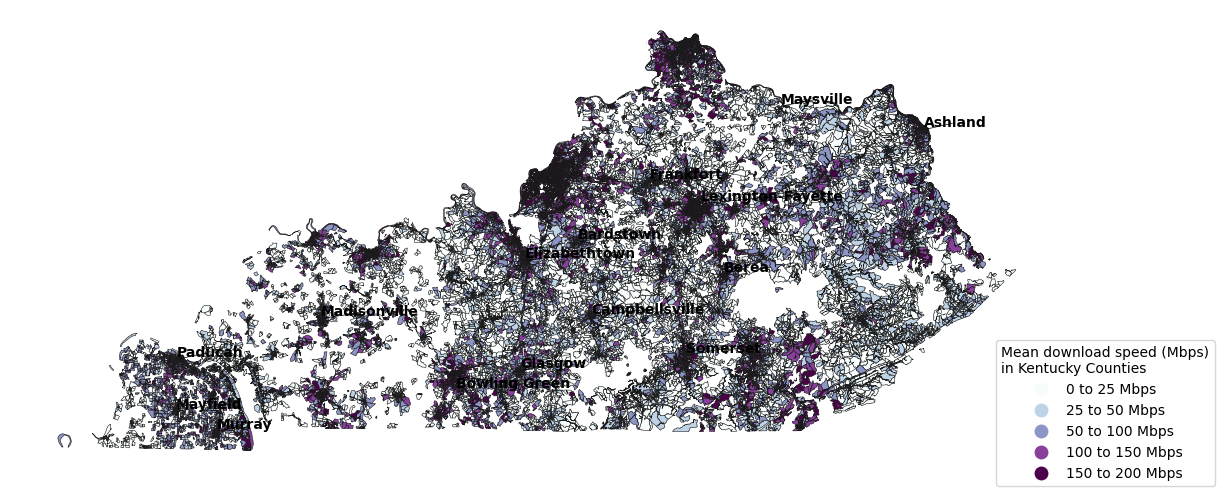

In [27]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Mean download speed (Mbps)\nin Kentucky Counties")

texts = []
for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)